In [92]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

# absolute path to ST modules
module_path = r'C:\Users\Jose Alvarez\Documents\Projects\CounterfactualSituationTesting\src'
# module_path = os.path.abspath(os.path.join('../src')) # or the path to your source code
sys.path.insert(0, module_path)
# local files
from src.situation_testing.situation_testing import SituationTesting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# change data path accordingly
data_path = os.getcwd() + '\\' + 'data' + '\\'
resu_path = os.getcwd() + '\\' + 'results' + '\\'

In [4]:
# factual dataset
org_df    = pd.read_csv(data_path + 'Karimi2020_v2.csv', sep='|', )
# counterfactual dataset
org_cf_df = pd.read_csv(resu_path + 'counterfactuals\\cf_Karimi2020_v2.csv', sep='|', )

### Set overall paremeters for test
We can run standard ST, counterfactual ST with/without the search centers, and counterfactual fairness. Notice that CF is included within cfST when incuding the search centers: these are th factual and counterfactual instances.

In [5]:
# attribute-specific params
feat_trgt = 'LoanApproval'
feat_trgt_vals = {'positive': 1, 'negative': -1}
# list of relevant features
feat_rlvt = ['AnnualSalary', 'AccountBalance']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 0, 'protected': 1}

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

In [6]:
res_df = org_df[['Gender', 'LoanApproval']].copy()
res_df['cf_LoanApproval'] = org_cf_df['LoanApproval'].copy()
res_df.head(5)

,Gender,LoanApproval,cf_LoanApproval
0,1,-1.0,-1.0
1,0,1.0,1.0
2,0,-1.0,-1.0
3,0,-1.0,-1.0
4,1,1.0,1.0


From one of the CLeaR reviewers: what is your Oracle?
I guess, in this world, it would be a world freed from systematic bias, meaning counterfactual fairness captures this discrepancy between worlds, no?

The world where $X_1$ and $X_2$ are born without $A$'s influence is a counterfactually fair world by definition from Kusner et al.!!!

In [7]:
print(res_df[(res_df['Gender'] == 1) & (res_df['LoanApproval'] == 1)].shape[0])
# vs
print(res_df[(res_df['Gender'] == 1) & (res_df['cf_LoanApproval'] == 1)].shape[0]) #ground truthc (if you will)

674
1050


In [8]:
test_df = org_df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['ST'] = st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                      sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                      k=n, alpha=alpha, tau=tau)

standardizing factual dataset


In [9]:
# get all neighborhoods for ST
stST_knn = st.res_dict_df_neighbors

In [10]:
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfST'] = cf_st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                           sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                           include_centers=False,
                           k=n, alpha=alpha, tau=tau)

standardizing factual dataset
standardizing counterfactual dataset


In [11]:
# get all neighnorhoods for cfST
cfST_knn = st.res_dict_df_neighbors

stST vs cfST:
- look at the cfST without centers (to be able to compare them)
- look at the c's that are shared between both methods: look at the distribution of each's ctr and tst
    - also look at the factual vs counterfactuals: average distance among this set
- look at the c's that are NOT shared between both methods and do the same

In [35]:
id = 5
#var = 'AnnualSalary'
var = 'AccountBalance'

print(org_df.iloc[id, :])
print(org_cf_df.iloc[id, :])

LoanApproval           1.000000
AnnualSalary      102000.000000
AccountBalance     26000.811689
u1                120000.000000
u2                 -3172.991276
Gender                 1.000000
Name: 5, dtype: float64
u_AnnualSalary       17141.06
u_AccountBalance     -3425.38
AnnualSalary        117796.35
AccountBalance       31905.19
LoanApproval             1.00
Gender                   1.00
Name: 5, dtype: float64


In [63]:
# org_df.iloc[cfST_knn[id]['ctr_idx'], :]

In [64]:
# org_df.iloc[stST_knn[id]['tst_idx'], :]

In [65]:
# org_cf_df.iloc[cfST_knn[id]['tst_idx'], :]

In [89]:
# sets of interest

# c in stST and in stCF
set1 = res_df[(res_df['ST'] > tau) & (res_df['cfST'] > tau)].index.to_list()

# c not in stST but in stCF
set2 = [c for c in res_df[(res_df['cfST'] > tau)].index.to_list() if c not in set1]

[3747, 3239, 420, 4749, 1808]


<AxesSubplot:xlabel='ID', ylabel='AccountBalance'>

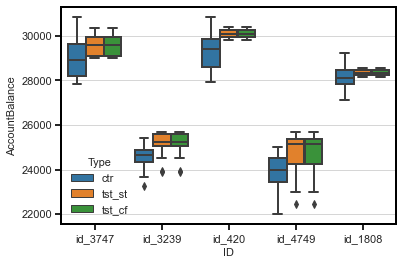

In [100]:
# let's look at those c's that appear both in stST and cfST
test_n = 5

test_c = random.sample(set1, test_n)
print(test_c)

var = ['AnnualSalary', 'AccountBalance']
temp_df_list = []

for c in test_c:
    
    temp_ctr = org_df.iloc[stST_knn[c]['ctr_idx'], :][var].copy()
    temp_ctr['ID'] = 'id_' + str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr

    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_st['ID'] = 'id_' + str(c)
    temp_tst_st['Type'] = 'tst_st'
    temp_df_list.append(temp_tst_st)
    del temp_tst_st
    
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_cf['ID'] = 'id_' + str(c)
    temp_tst_cf['Type'] = 'tst_cf'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

# box_plot_data
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AccountBalance'],
            hue = box_plot_data['Type'])

In [ ]:
# Get summary stats

In [96]:
[c for c in set2 if c in set1]

[]

In [ ]:
stST_knn[5]

In [ ]:
cfST_knn[5]

In [ ]:
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfSTwith'] = cf_st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                               sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                               include_centers=True,
                               k=n, alpha=alpha, tau=tau)

In [ ]:
res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
res_df[res_df['Gender']==1].head(10)

1) We need to compare ST vs cfST
- check that all STs are in cfST
- focus on ST $\cap$ cfST: plot the distribution of group vs test group per k for X1 and X2
- do the same for those not shared

We would like to see that when ST and cfST agree we get "tighter" control and test groups: notice that the control groups across tools here should be identical, meaning the SOURCE OF VARIATION COMES FROM THE TEST GROUP.

We can also play with/without center here, but since ST doesn't use the center, it makes sense to use cfSt without centers for this comparisson.

We want to show/make the case: idealized comparison vs fairness given the difference.

2) We also need to compare cfST vs CF
- check that all CFs are in cfST (at least when including the center)
- focus on cases where CF doesn't identify discrimination: highlight that we need more than the individual comparison

We would like to see the limitations of relying exclusively on counterfactual fairness for detecting discrimination: for the law it's not enough. Compare with and without centers: in the former, we are by default including CF in the comparisson and the variation around it. 

3) Finally, compare all three: when do they coincide?

In [ ]:
len(res_df[res_df['ST'] > tau].index)

In [ ]:
print(res_df[(res_df['ST'] > tau) & (res_df['cfST'] > tau)].shape)
print(res_df[(res_df['ST'] > tau) & (res_df['cfSTwith'] > tau)].shape) # all i in ST are in cfST: as expected

In [ ]:
len(res_df[res_df['CF'] == True].index)

In [ ]:
print(res_df[(res_df['cfST'] > tau) & (res_df['CF'] == True)].shape)
print(res_df[(res_df['cfSTwith'] > tau) & (res_df['CF'] == True)].shape) # all CFs are in cfST when including the centers: as expected
# then the CF is the lower bound (it seems) of cfST with centers!

In [ ]:
# explore the distributions... ctr group vs tst groups: show the disimilar individuals for the same i factual
# ... look at the cases where CF failed / didn't fail wrt to cfST: box plots???